# Entropy-Gated Market Regime Classifier with Hidden Markov Models

## Introduction

This project extends LSEG's Market Regime Detection using Statistical Methods and Machine Learning Approaches by introducing an entropy-gated post-model decision layer aimed at improving regime-classification stability.

The proposed extension operates on the posterior state probabilities produced by a Hidden Markov Model and a Gaussian Mixed Model, using Shannon Entropy to quantify the model's decision uncertainty at each step. Entropy is employed to gate regime-classification; ergo, allowing or suppressing regime transitions depending on the confidence of the inferred state distribution.

The effectiveness of this entropy-gated framework is evaluated by comparing its behaviour against the baseline models across a set of proxy-truth diagnostics, including responsiveness to shock returns and regime stability across varying volatility conditions.



## Data Ingestion and Engineering

This project continues to ingest futures contracts on the S&P 500 (ESc1) as LSEG's Blueprint.

#### Install and import packages

In [1]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import refinitiv.data as rd
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import GaussianMixture
import plotly.express as px
import warnings
import math


warnings.filterwarnings('ignore')

In [3]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x1ee43161420 {name='workspace'}>

## Data Ingestion and Engineering

In this section, prices from 01-01-1997 to 01-01-2025 are ingested and prepared for feeding to the regime detection algorithm.

In [4]:
trading_instrument = "ESc1"
prices = rd.get_history(
    universe = trading_instrument,
    fields = ['TRDPRC_1'],
    start = "1997-01-01",
    end = "2025-01-01"
)

prices = prices.loc[:,~prices.columns.duplicated()]
prices

ESc1,TRDPRC_1
Date,
1997-09-09,934.25
1997-09-10,917.5
1997-09-11,908.75
1997-09-12,924.5
1997-09-15,921.0
...,...
2024-12-24,6099.0
2024-12-26,6091.5
2024-12-27,6029.25


### Plotting Price of S&P 500 E-mini Futures (Esc1) Price Series - Jan 1997 to Jan 2025

In [5]:
prices.columns.name = trading_instrument
fig = px.line(prices["TRDPRC_1"])
fig.update_layout(
    title = "ESc1 Price Evolution (1997-2025): S&P 500 E_mini Future from LSEG Workspace",
    title_x = 0.5,
    xaxis_title = "Year",
    yaxis_title = "Price"
)

## Feature Engineering

This section focuses on the feature-engineering of the pipeline, transforming raw price data into observables suitable for training the Hidden Markov Model.

The engineered features were derived from LSEG's Blueprint. Thus, within the function prepare_data_for_model_input, it computes the log return on a 7-day moving average window of historical close prices. Log returns are preferred over simple returns due to their symmetrical and additive properties, which are more compatible with probabilistic time-series models.

Applying log returns on a 7-day moving average further prevents over-sensitivity to high-frequency noise in the price series, reducing sensitivity to transient fluctuations, whilst preserving the underlying regime-level dynamics of the asset.

In [6]:
def prepare_data_for_model_input(prices, ma):
    instrument = prices.columns.name
    prices[f"{instrument}_ma"] = prices.rolling(ma).mean()
    prices[f"{instrument}_log_return"] = np.log(prices[f"{instrument}_ma"]/prices[f"{instrument}_ma"].shift(1)).dropna()
    # prices becomes an enhanced dataframe containing additional observable prameters suited for ML Training

    prices.dropna(inplace = True)
    prices_array = np.array([[q] for q in prices [f"{instrument}_log_return"].values])

    return prices, prices_array

    

The following code is responsible for calling the feature engineering method prepare_data_for_model_input and passing the prices dataframe as a parameter

In [7]:
prices, prices_array = prepare_data_for_model_input(prices, 7)
prices

ESc1,TRDPRC_1,ESc1_ma,ESc1_log_return
Date,,,
1997-09-18,948.25,930.000000,0.002153
1997-09-19,960.25,936.107143,0.006545
1997-09-22,965.5,944.214286,0.008623
1997-09-23,961.75,949.535714,0.005620
1997-09-24,953.0,954.107143,0.004803
...,...,...,...
2024-12-24,6099.0,5978.785714,0.001142
2024-12-26,6091.5,5980.928571,0.000358
2024-12-27,6029.25,5977.678571,-0.000544


# Regime Detection

This section defines the class "RegimeDetection" enabling for the calling of either the Hidden Markov Model or the Gaussian Mixture Model for their initialisation in later segments of the code. This class retains the same architecture from LSEG's Blueprint Pipeline.

In [8]:
class RegimeDetection:
    '''
    Wrapper class for regime detection models.
    Supports both the Hidden Markov Model (HMM) and Gaussian Mixture Model (GMM)
    '''

    def get_regimes_hmm(self, input_data, params):
        '''
        Initialises a Hidden Markov Model with the specified parameters from params.
        Fits the model to the input data
        
        :param input_data: array-like
            an array containing the log prices of the observed instrument.
        :param params: dict 
            Dictionary of parameters to initialise the model.
        '''
        hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model
    
    def get_regimes_gmm(self, input_data, params):
        '''
        Initialises a Gaussian Mixture Model with the specified parameters from params.
        Fits the model to the input data
        
        :param input_data: array-like
            an array containing the log prices of the observed instrument.
        :param params: dict 
            Dictionary of parameters to initialise the model.
        '''
        gmm_model = self.initialise_model(GaussianMixture(), params).fit(input_data)
        return gmm_model

    def initialise_model(self, model, params):
        for parameter, value in params.items():
            setattr(model, parameter, value)
        return model

Defining a function responsible for plotting the hidden states, with the close prices against the time period.

In [9]:
def plot_hidden_states(hidden_states, prices_df, price_col = "TRDPRC_1"):
    
    '''
    Input:
    hidden_states(numpy.ndarray) - array of predicted hidden states
    prices_df(df) - dataframe of close prices
    
    Output:
    Graph showing hidden states and prices
    
    '''
    
    colors = ['blue', 'green']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()
 
    for i in range(n_components):
        mask = hidden_states == i
        print(f"Number of observations for State{i}L {mask.sum()}")

        fig.add_trace(
            go.Scatter(
                x = prices_df.index[mask],
                y = prices_df.loc[mask, price_col],
                mode = "markers",
                name = f"Hidden State {i}",
                marker = dict(size = 4, color = colors[i])
            )
        )
    
    fig.update_layout(
        height = 400,
        width = 900,
        legend= dict(yanchor = "top", y = 0.99, xanchor = "left", x = 0.01),
        margin = dict(l=20, r = 20, t=20, b=20)
    )

    fig.show()


In [10]:
# Intialises a Regime Detection Object
regime_detection = RegimeDetection()

# Market Regime Classification with Hidden Markov Model and Gaussian Mixture Model

## Markov Hidden Model

At this conjecture, a Hidden Markov Model will be instantiated with parameters derived from LSEG's Blueprint Model. The model will be trained on the whole dataset at once. 

While this introduces lookahead bias, making it unsuitable for forecasting. Instead, it will serve as a baseline comparator for the feedforward training models - simulating model performance in forecasting market regimes.

The plot below plots the inferred hidden states against time, helping identify distinct market regimes.

In [11]:
params = {"n_components":2, "covariance_type":"full", "random_state":100}
hmm_model = regime_detection.get_regimes_hmm(prices_array, params)
hmm_states = hmm_model.predict(prices_array)
plot_hidden_states(np.array(hmm_states), prices[["TRDPRC_1"]])

Number of observations for State0L 964
Number of observations for State1L 5909


### Calculating Entropy at each Time Step

To quantify model uncertainty, the confidence of the Hidden Markov Model is derived from its posterior state probabilities. These probabilitie form a discrete distribution over the set of hidden states inferred by the model. Shannon Entropy is subsequently computed to measure classification uncertainty.

In [12]:
posteriors = hmm_model.predict_proba(prices_array)

def shannon_entropy(probs):
    '''
    This function uses the Shannon Entropy equation to quantify model uncertainty through the use of the model's returned state probabilities
    contained in the probs parameter.
    
    '''
    entropy = -np.sum(probs * np.log(probs), axis = 1)
    return entropy

entropy_hmm = shannon_entropy(posteriors)
# Adding dates back to the entropy values and accounting for the delay
# introduced by the moving window
entropy_series = pd.Series(entropy_hmm, index = prices.index[-len(entropy_hmm):])

# Plotting Entropy Series
px.line(entropy_series)

# Finding the Average Entropy Value of the HMM Model
avg_h_hmm = np.average(entropy_hmm)

In [13]:
# Finding the average Entropy of the HMM
avg_h_hmm = np.average(entropy_hmm)
print(avg_h_hmm)

0.11350521298400856


## Gaussian Mixture Model

A Gaussian Mixture Model is also introduced and is trained on the whole price_array dataset. This was performed to evaluate the overall performance of the model against the Hidden Markov Model; furthermore, to provide a baseline performance comparator for its entropy-gated derivatives.

In [14]:
params = {'n_components':2, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}

gmm_model = regime_detection.get_regimes_gmm(prices_array, params)
gmm_states = gmm_model.predict(prices_array)
plot_hidden_states(np.array(gmm_states), prices[["TRDPRC_1"]])

Number of observations for State0L 6342
Number of observations for State1L 531


### Calculating Entropy at Each Time Step

Similar to the Hidden Markov Model, the entropy at each time step is used to quantify the model's uncertainty in its regime classification decisions.

In [15]:
posteriors = gmm_model.predict_proba(prices_array)

def shannon_entropy(probs):
    '''
    This function uses the Shannon Entropy equation to quantify model uncertainty through the use of the model's returned state probabilities
    contained in the probs parameter.
    
    '''
    entropy = -np.sum(probs * np.log(probs), axis = 1)
    return entropy

entropy_gmm = shannon_entropy(posteriors)
# Adding dates back to the entropy values and accounting for the delay
# introduced by the moving window
entropy_series = pd.Series(entropy_gmm, index = prices.index[-len(entropy_gmm):])

# Plotting Entropy Series
px.line(entropy_series)

In [16]:
# Finding the average entropy value for the GMM
avg_h_gmm = np.average(entropy_gmm)
print(avg_h_gmm)

0.3766316957171985


It is observable that the GMM has a greater baseline uncertainty compared to the Hidden Markov Model. Its graph illustrates an average entropy value of 0.377 (3s.f.) - whilst the HMM was at 0.114. Therefore, the GMM is approximately 230% more uncertain in market regime classification.

## Real-Time Forecasting Performance Simulation

### Feed-Forward Training Hidden Markov Model

From LSEG's Blueprint, feedforward-training is then implemented, where the model is retrained incrementally as "new" data becomes available. This simulates the real-time forecasting performance of the HMM.

In [17]:
def feed_forward_training(model, params, prices, split_index, retrain_step):
    '''
    Input:
    model (<class 'method'>) - either gmm (Gaussian Mixture Models) or hmm (Hidden Markov Model)
    params (dict) - dictionary of parameters for a model
    prices (df) - Dataframe of close prices
    split_index (str) - index to split initial traing dataset and out of sample testing set
    retrain_step (int) - number of observations after which we retrain the model
    
    Output:
    states_pred (numpy.ndarray) - array of predicted hidden states
    '''
    # train/test split and initial model training
    init_train_data = prices[:split_index]
    test_data = prices[split_index:]
    rd_model = model(init_train_data, params)
    entropies = []
    
    # predict the state of the next observation
    states_pred = []
    for i in range(math.ceil(len(test_data))):
        split_index += 1
        preds = rd_model.predict(prices[:split_index]).tolist()
        states_pred.append(preds[-1])

        proba = rd_model.predict_proba(prices[:split_index])[-1]
        entropy = -np.sum(proba * np.log(proba))
        entropies.append(entropy)
        
        # retrain the existing model
        if i % retrain_step == 0:
            rd_model = model(prices[:split_index], params)
            
    return  states_pred, entropies

In [18]:
model_hmm =  regime_detection.get_regimes_hmm
params = {'n_components':2, 'covariance_type': 'full', 'random_state':100}
split_index = np.where(prices.index > '2006-01-01')[0][0]
states_pred_hmm, entropies_fft_hmm = feed_forward_training(model_hmm, params, prices_array, split_index, 3)

In [19]:
plot_hidden_states(np.array(states_pred_hmm), prices[["TRDPRC_1"]][split_index:])
# Adding Dates back to the Entropy Values
entropy_series = pd.Series(entropies_fft_hmm, index = prices.index[-len(entropies_fft_hmm):])
px.line(entropy_series)

Number of observations for State0L 368
Number of observations for State1L 4418


In [20]:
# Quantifying the average entropy value of the FFT HMM Model
avg_h = np.average(entropies_fft_hmm)
print(avg_h)

0.10589701351985825


The feedforward model was implemented to assess the forecasting performance of the HMM by only incrementally providing it with price data for the ESc1 E-mini futures contract - preventing the effects of look ahead bias.

### Implementing Feedforward Training with Entropy-Gating for HMM

In [21]:
def entropy_gated_training(model, params, prices, split_index, retrain_step, entropy_threshold):
    '''
    Input:
    model (<class 'method'>) - either gmm (Gaussian Mixture Models) or hmm (Hidden Markov Model)
    params (dict) - dictionary of parameters for a model
    prices (df) - Dataframe of close prices
    split_index (str) - index to split initial traing dataset and out of sample testing set
    retrain_step (int) - number of observations after which we retrain the model
    
    Output:
    states_pred (numpy.ndarray) - array of predicted hidden states
    '''
    # train/test split and initial model training
    init_train_data = prices[:split_index]
    test_data = prices[split_index:]
    rd_model = model(init_train_data, params)
    
    gated_states = []
    prev_state = None

    entropies = []

    for i in range(math.ceil(len(test_data))):
        split_index += 1
        preds = rd_model.predict(prices[:split_index]).tolist()

        # If at a retrain step, retrain the model
        if i % retrain_step == 0:
            rd_model = model(prices[:split_index], params)
        
        proba = rd_model.predict_proba(prices[:split_index])[-1]
        entropy = -np.sum(proba * np.log(proba))
        entropies.append(entropy)

        # If entropy is lower than the specified entropy-threshold, switch to proposed regime
        if entropy < entropy_threshold:
            state = np.argmax(proba)
        else:
            state = prev_state if prev_state is not None else np.argmax(proba)
        
        gated_states.append(state)
        prev_state = state

    return  gated_states, entropies

In [22]:
model_hmm =  regime_detection.get_regimes_hmm
params = {'n_components':2, 'covariance_type': 'full', 'random_state':100}
split_index = np.where(prices.index > '2006-01-01')[0][0]
gated_states_pred_hmm, entropies_hmm = entropy_gated_training(model_hmm, params, prices_array, split_index, 10, 0.5)
plot_hidden_states(np.array(gated_states_pred_hmm), prices[["TRDPRC_1"]][split_index:])

Number of observations for State0L 370
Number of observations for State1L 4416


### Feed-Forward Training Gaussian Mixed Model

At this juncture, feedforward training was also applied to a GMM to assess its forecasting capabilities. 

In [23]:
model_gmm =  regime_detection.get_regimes_gmm
params = {'n_components':2, 'covariance_type':"full", 'random_state':100, 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
split_index = np.where(prices.index > '2006-01-01')[0][0]
states_pred_gmm, entropies_fft_gmm = feed_forward_training(model_gmm, params, prices_array, split_index, 100)
plot_hidden_states(np.array(states_pred_gmm), prices[["TRDPRC_1"]][split_index:])


Number of observations for State0L 3291
Number of observations for State1L 1495


In [24]:
# Adding Dates back to Entropy Values
entropy_series = pd.Series(entropies_fft_gmm, index = prices.index[-len(entropies_fft_gmm):])
px.line(entropy_series)

In [25]:
# Finding the average entropy of the GMM
avg_h_gmm = np.average(entropies_fft_gmm)
print(avg_h_gmm)

0.41166142937067357


With feedforward training, while the HMM retained its relative confidence in market regime classification, achieving an average entropy value of 0.114 (3s.f.) and 0.106 (3s.f.) for the baseline and FFT versions, respectively - indicating a 7.0% differnce. The GMM encountered greater classification uncertainty when attempting to perform real-time forecasting, increasing average entropy values from 0.377 to 0.412 - indicating a 9.3% increase. This illustrates the decreased effectiveness of the GMM in forecasting - compared to HMMs - when operating with incomplete data.

### Implementing Feedforward Training with Entropy-Gating for GMM

In [26]:
model_gmm =  regime_detection.get_regimes_gmm
params = {'n_components':2, 'covariance_type':"full", 'random_state':100, 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
split_index = np.where(prices.index > '2006-01-01')[0][0]
gated_states_gmm, _ = entropy_gated_training(model_gmm, params, prices_array, split_index, 20, 0.3)
plot_hidden_states(np.array(states_pred_gmm), prices[["TRDPRC_1"]][split_index:])


Number of observations for State0L 3291
Number of observations for State1L 1495


## Statistical Evaluation of Entropy-Gated Models

Due to the inherent stability of the baseline Hidden-Markov Model and the comparatively higher average classification uncertainty of the Gaussian Mixture Model, the latter offers greater potential for performance enhancements via post-model entropy-based gating.

This section quantitatively evaluates the effectiveness of the Entropy-Gated Gaussian Mixture Model; specifically, measuring its ability to:
1) Improving classification stability during low-to-medium volatility market conditions by reducing unnecessary state switches.
2) Preserve responsivness during high-volatility periods, ensuring the model adapts rapidly when market regime shifts.

### Flip-Flop Analysis

The Flip-Flop metric is used to quantify the sensitivity of the models to microstructure noise. A reduction in total number of flip-flops within the Gated Model indicates a reduction in noise-driven indecision.

In [27]:
def count_flip_flops(states):
    '''
    Analyses a moving window of size 3, checking if there are intermittent switches between a continuous market regime - indicating decision largely driven by
    market data noise.
    
    :param states: array
        An array consisting of the state classifications of the model
    '''
    flips = 0
    for i in range(1, len(states) - 1):
        if states[i] != states[i-1] and states[i] != states[i+1]:
            flips += 1

    return flips

### Time-to-React after Shock Returns

This metric aims to quantify the responsiveness of the model by measuring the number of days required by the model to respond to large price move (i.e., a shock) by switching the market regime classification.

This metric evaluates whether the model sacrifices responsiveness to achieve greater market regime classification stability.

In [28]:
def time_to_react(prices, states, shock_threshold = 0.3):
    '''
    Responsible for detecting market regions where a sharp fluctuation in asset price occured - i.e., an absolute change of 3%. 
    
    :param prices: Dataframe of close prices
    :param states: array of market classifications made by the model
    :param shock_threshold: Threshold indicating absolute percentage change classifiable as a shock return
    '''
    # Calculates the returns across the prices series
    returns = prices.pct_change().fillna(0)
    # Stores the index of shock returns (their date) - i.e., shocks that exceed the defined return threshold
    shock_indices = returns[returns.abs() > shock_threshold].index

    delays = []
    for idx in shock_indices:
        # Acquires the actual index of shock returns
        start_idx = prices.index.get_loc(idx)
        last_state = states[start_idx]
        for j in range(start_idx + 1, len(states)):
            if states[j] != last_state:
                # Measures the difference in days between shock return and regime switch
                delays.append(j - start_idx)
                break
    return delays



### Low Volatility Switch Count

In [29]:
flip_flops = count_flip_flops(states_pred_gmm)
print("Number of flip flops (baseline): " + f'{flip_flops}')

gated_flip_flop_test = count_flip_flops(gated_states_gmm)
print("Number of flip  (gated): " + f'{gated_flip_flop_test}')

Number of flip flops (baseline): 84
Number of flip  (gated): 0


We can see that the entropy-gated derivative of the FFT-GMM, it is capable of fully removing all spurious market regime classifications, removing all 84 detected rapid changes in market classifications.

#### System Responsiveness

In [30]:
ttr = time_to_react(prices[-len(states_pred_gmm):], states_pred_gmm)
print(np.average(ttr))

ttr_gated = time_to_react(prices[-len(gated_states_gmm):], gated_states_gmm)
print(np.average(ttr_gated))

61.33914152146196
705.5910364145658


## Tuning Entropy Threshold for Entropy-Gated GMM Model

This section endeavours to determine an optimal entropy threshold for the Entropy-Gated GMM Model - identifying a Pareto Compromise between the system's classification stability and overall responsiveness by measuring the reduction in unnecessary regime classification shifts (i.e., flip-flops) and the system's time to response to a shock-return market event (i.e., sudden increase in market volatility)

In [31]:
# From Baseline Model
# Determining system responsiveness
ttr_base = time_to_react(prices[-len(states_pred_gmm):], states_pred_gmm)
avg_base = np.mean(ttr_base)
# Determining number of flip-flops
baseline_flips = count_flip_flops(states_pred_gmm)

In [32]:
# Assessing model performance at various entropy threshold levels
thresholds = np.linspace(0.3, 0.5, 10)

latency_diffs = []
flip_diffs = []

for thresh in thresholds:
    gated_states, _ = entropy_gated_training(model_gmm, params, prices_array, split_index, 100, thresh)

    # Metric 1: Reaction Time
    ttr = time_to_react(prices[-len(gated_states):], gated_states)
    avg_latency = np.mean(ttr)
    latency_diffs.append(((avg_latency - avg_base)/avg_base)*100)

    # Metric 2: Reduction in flips
    gated_flips = count_flip_flops(gated_states)

    flip_diffs.append(baseline_flips - gated_flips)

In [33]:
print(latency_diffs)
print(flip_diffs)

[558.8894575008478, 538.9922172099388, 209.5385640601237, 116.47348728697939, 109.34361206075222, 108.35087535934318, 108.6616692393091, 109.47334075618443, 103.1249595160769, 85.52382798581924]
[84, 84, 84, 84, 82, 80, 81, 79, 79, 78]


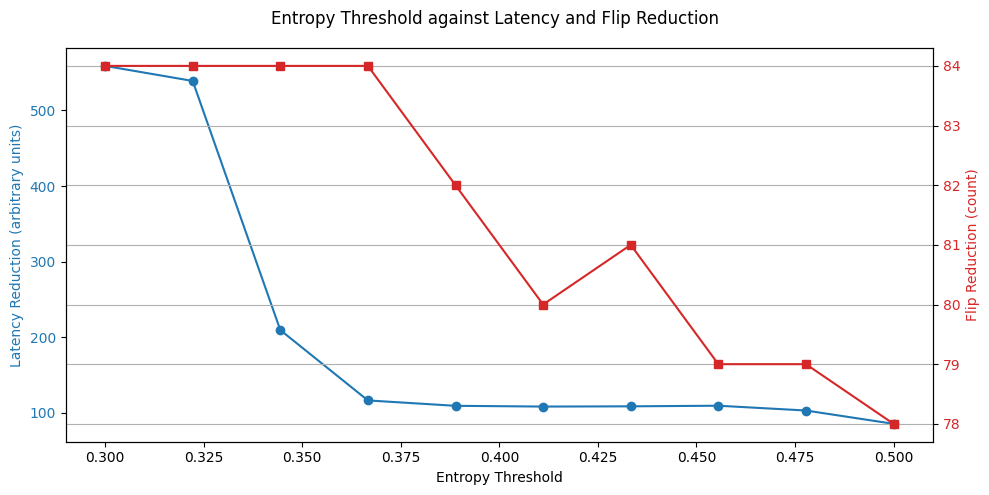

In [34]:
fig, ax1 = plt.subplots(figsize=(10,5))
# Plotting Latency on the left y-axis
color1 = "tab:blue"
ax1.set_xlabel("Entropy Threshold")
ax1.set_ylabel("Latency Reduction (arbitrary units)", color = color1)
ax1.plot(thresholds, latency_diffs, color = color1, marker = "o", label = "Latency")
ax1.tick_params(axis = "y", labelcolor = color1)

# Creating Second y-axis
ax2 = ax1.twinx()

# Plotting reduction in flips on the right y-axis
color2 = "tab:red"
ax2.set_ylabel("Flip Reduction (count)", color = color2)#
ax2.plot(thresholds, flip_diffs, color = color2, marker = "s", label = "Flip Reduction")
ax2.tick_params(axis = "y", labelcolor = color2)

# Title and Grid
fig.suptitle("Entropy Threshold against Latency and Flip Reduction")
fig.tight_layout()
plt.grid(True)
plt.show()


## Statistical Analysis of HMM and GMM Stability

In [35]:
# Hidden Markov Model
# Average
hmm_entropy_avg = np.average(entropies_hmm)
# Standard-Deviation
hmm_entropy_std = np.std(entropies_hmm)
print(f"HMM Entropy: 1) Average: {hmm_entropy_avg}', 2) Standard Deviation: {hmm_entropy_std}")

# Hidden Markov Model
# Average
gmm_entropy_avg = np.average(entropy_gmm)
# Standard-Deviation
gmm_entropy_std = np.std(entropy_gmm)
print(f"GMM Entropy: 1) Average:  {gmm_entropy_avg}, 2) Standard Deviation: {gmm_entropy_std}")

HMM Entropy: 1) Average: 0.10609892327939537', 2) Standard Deviation: 0.15303093600720483
GMM Entropy: 1) Average:  0.3766316957171985, 2) Standard Deviation: 0.12190828170594083


## Conclusion

This project evaluated the effectiveness of an entropy-gated regime classification mechanism in improving the stability of unsupervised clustering models applied to financial market states. Two architectures were considered: 1) Gaussian Mixture Models (GMMs) and 2) Hidden Markov Models (HMMs).

Analysis of entropy distirbutions reavealed that HMMs are inherently more certain with classification decisions, with an average entropy of 0.106 and standard deviation of 0.153 compared to GMMs average entropy of 0.0.377 and standard deviation of 0.122 which exhibit higher classification uncertainty due to their purely statistical distribution nature.

The introduction of an entropy-gating layer significantly reduced regime-swithing noise in GMMs under low-to-medium volatility conditions, removing 100% of all low-to-medium volatility decision uncertainty - indicating the complete mitgation of microstructure-noise affecting the decision of the model. However, this increase in classification stability resulted in decreased responsiveness to market shocks - as it resulted to a >100% increase in decision latency.  Therefore, to quantify this trade-off, a Pareto-style analysis of entropy thresholds and identified an optimal balance at a threshold of approximately 0.37 - notably close to the average entropy of the baseline feed-forward-trained GMM of 0.41
. At this threshold, the model achieved the greatest reduction in uncessary regime classification flips while maitaining the lowest possible reactivity during high-volatility conditions.

While Shannon entropy provided an interpretable and tractable proxy for quantifying uncertainty, the resulting incrase in latency highlighted the inherent trade-off between reactivity and stability. This motivates further exploration of more context-aware uncertainty metrics.